# Get the Data

In [1]:
import os
from pymongo import MongoClient
from typing import Dict, List, Any, Optional 
from datetime import datetime


In [2]:
import json
import re

In [3]:
import pandas as pd

In [4]:
# # Configuration
# MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017")
# DB_NAME = "digikala"
# PRODUCTS_COLLECTION = "products"

# class ProductDataReader:
#     """
#     A class to read product data from Digikala MongoDB database and convert to pandas DataFrame.
#     """
    
#     def __init__(self, mongo_uri: str = MONGO_URI, db_name: str = DB_NAME):
#         """
#         Initialize the MongoDB connection.
        
#         Args:
#             mongo_uri: MongoDB connection string
#             db_name: Database name
#         """
#         self.client = MongoClient(mongo_uri)
#         self.db = self.client[db_name]
#         self.products_collection = self.db[PRODUCTS_COLLECTION]
        
#     def get_collection_info(self) -> Dict[str, Any]:
#         """
#         Get basic information about the products collection.
        
#         Returns:
#             Dictionary containing collection statistics
#         """
#         try:
#             total_docs = self.products_collection.count_documents({})
#             sample_doc = self.products_collection.find_one()
            
#             return {
#                 "total_documents": total_docs,
#                 "sample_document": sample_doc,
#                 "collection_name": PRODUCTS_COLLECTION,
#                 "database_name": DB_NAME
#             }
#         except Exception as e:
#             print(f"Error getting collection info: {e}")
#             return {}
    
#     def get_specifications(self , spec_groups: List[Dict[str, Any]]) -> Dict[str, str]:
#         # ---------- helpers ----------
#         persian_digits = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")
#         arabic_digits = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")

#         def to_ascii(s: Any) -> str:
#             if s is None:
#                 return ""
#             s = str(s).translate(persian_digits).translate(arabic_digits)
#             return "".join(ch for ch in s if 32 <= ord(ch) <= 126)

#         def join_vals(v):
#             if not v:
#                 return ""
#             if isinstance(v, (list, tuple)):
#                 return ", ".join([str(x) for x in v if x is not None])
#             return str(v)

#         def first_number(text: str) -> str:
#             t = to_ascii(text)
#             m = re.search(r"(\d+(?:\.\d+)?)", t)
#             return m.group(1) if m else ""

#         def extract_year(text: str) -> str:
#             t = to_ascii(text)
#             m = re.search(r"\b(20\d{2}|19\d{2})\b", t)
#             return m.group(1) if m else ""

#         def extract_size_3nums_mm(text: str) -> str:
#             # Replace ×, X, * with x BEFORE to_ascii
#             t = re.sub(r"[×X*]", "x", str(text))
#             t = to_ascii(t)
#             t = re.sub(r"\s*میلی[\u200c\s]*متر\s*", "", t)
#             t = re.sub(r"[\u200e\u200f\u202a-\u202e]", "", t)
#             nums = re.findall(r"\d+(?:\.\d+)?", t)
#             if len(nums) == 3:
#                 return "x".join(nums)
#             return ""

#         def extract_inch(text: str) -> str:
#             t = to_ascii(text).lower()
#             m = re.search(r"(\d+(?:\.\d+)?)\s*(inch|in|'|\")", t)
#             if m:
#                 return m.group(1)
#             m = re.search(r"\b(\d+(?:\.\d+)?)\b", t)
#             return m.group(1) if m else ""

#         # NEW: map Persian category to high/mid/low
#         def map_category(value: str) -> str:
#             raw = (value or "").replace("\u200c", "").strip().lower()
#             # Keep Persian for matching before ASCII stripping
#             if any(k in raw for k in ["پرچم", "پرچمدار", "پرچم دار","بالا رده"]):
#                 return "high"
#             if any(k in raw for k in ["ميان رده", "میان رده", "میانرده", "ميان‌رده", "میان‌رده"]):
#                 return "mid"
#             if any(k in raw for k in ["پايين رده", "پایین رده", "پایینرده","اقتصادی"]):
#                 return "low"
#             # English fallbacks
#             t = to_ascii(raw)
#             if "flagship" in t: return "high"
#             if "mid" in t: return "mid"
#             if "low" in t or "entry" in t: return "low"
#             return ""

#         def extract_storage_gb(text: str) -> str:
#             t_raw = text or ""
#             t = to_ascii(t_raw).lower()

#             # TB
#             m_tb = re.search(r"\b(\d{1,2})\s*(tb|tib|ترابایت|ترابايت|terabyte|terabytes)\b", t)
#             if m_tb:
#                 gb_val = float(m_tb.group(1)) * 1024
#                 return str(gb_val)

#             # GB
#             m_gb = re.search(r"\b(\d{1,4})\s*(gb|gib|گیگابایت|گيگابايت|gigabyte|gigabytes)\b", t)
#             if m_gb:
#                 return str(float(m_gb.group(1)))

#             # MB
#             m_mb = re.search(r"\b(\d{1,5})\s*(mb|mib|مگابایت|مگابايت)\b", t)
#             if m_mb:
#                 gb_val = float(m_mb.group(1)) / 1024
#                 return str(round(gb_val, 3))

#             # Fallback: Persian-only or number-only (if no unit found)
#             n_gb = first_number(t_raw) if "گیگ" in t_raw or "g" in t else ""
#             if n_gb:
#                 return str(float(n_gb))
#             n_mb = first_number(t_raw) if "مگ" in t_raw or "m" in t else ""
#             if n_mb:
#                 gb_val = float(n_mb) / 1024
#                 return str(round(gb_val, 3))
#             n_tb = first_number(t_raw) if "ترا" in t_raw or "t" in t else ""
#             if n_tb:
#                 gb_val = float(n_tb) * 1024
#                 return str(gb_val)

#             return ""

#         # ---------- flatten spec table ----------
#         flat = {}
#         try:
#             for group in spec_groups if isinstance(spec_groups, list) else []:
#                 for attr in group.get("attributes", []) or []:
#                     t = str(attr.get("title", "")).strip()
#                     v = join_vals(attr.get("values", []))
#                     if t and v and t not in flat:
#                         flat[t] = v
#         except Exception:
#             pass

#         norm = lambda s: str(s).strip().lower()  # noqa: E731
#         def vby(keys: List[str]) -> str:
#             keys_normed = [norm(x) for x in keys]
#             for k in list(flat.keys()):
#                 if norm(k) in keys_normed:
#                     return flat[k]
#             return ""

#         # ---------- outputs (edited) ----------
#         out = {
#             "os": "",
#             "introduce_date": "",
#             "category": "",
#             "size": "",
#             "weight": "",
#             "display_technology": "",
#             "refresh_rate": "",
#             "size_screen_inch": "",
#             "display_to_body_ratio": "",
#             "pixel_per_inch": "",
#             "cpu_model": "",
#             "storage_gb": "",
#             "ram_gb": "",
#             "internet": "no",
#             "camera_num": "",
#             "camera_resolution_mp": "",
#             "video": "",
#             "battery_power_mah": "",        }

#         # simple direct
#         out["size"] = extract_size_3nums_mm(vby(["ابعاد", "size", "dimension", "dimensions"]))
#         out["weight"] = first_number(vby(["وزن", "weight"]))

#         # category mapping (high/mid/low)
#         cat_raw = vby(["دسته ‌بندی", "دسته بندی", "category"])
#         out["category"] = map_category(cat_raw)

#         # os
#         os_val = to_ascii(vby(["سیستم عامل", "os", "operating system"]))
#         if not os_val:
#             any_text = to_ascii(" ".join(flat.values())).lower()
#             if "android" in any_text:
#                 os_val = "Android"
#             elif "ios" in any_text or "i os" in any_text:
#                 os_val = "iOS"
#         out["os"] = os_val

#         # introduce year
#         out["introduce_date"] = extract_year(vby(["تاریخ معرفی", "زمان معرفی", "introduce date", "introduction date"]))

#         # display
#         out["display_technology"] = to_ascii(vby(["فناوری صفحه‌ نمایش", "فناوری صفحه نمایش", "display technology", "panel", "فناوری نمایش"]))
#         out["refresh_rate"] = first_number(vby(["نرخ به‌روزرسانی تصویر", "نرخ بروزرسانی", "refresh rate"]))
#         out["size_screen_inch"] = extract_inch(vby(["اندازه", "اندازه صفحه", "اندازه صفحه نمایش", "display size"]))
#         dbr_txt = vby(["نسبت صفحه‌ نمایش به بدنه", "نسبت نمایشگر به بدنه", "screen-to-body ratio", "display to body ratio"])
#         out["display_to_body_ratio"] = first_number(dbr_txt)
#         out["pixel_per_inch"] = first_number(vby(["تراکم پیکسلی", "ppi", "pixel density"]))

#         # CPU/GPU
#         out["cpu_model"] = to_ascii(vby(["تراشه", "چیپست", "chipset", "soc", "پردازنده", "cpu"]))


#         # Memory (robust)
#         out["storage_gb"] = extract_storage_gb(vby(["حافظه داخلی", "storage", "internal storage"]))
#         out["ram_gb"] = extract_storage_gb(vby(["مقدار RAM", "ram", "حافظه رم"]))

      
#         # Networks
#         nets_txt = " ".join([
#             vby(["شبکه‌های مخابراتی", "network", "networks"]),
#             vby(["شبکه‌های ارتباطی قابل پشتیبانی", "communication networks"]),
#         ])
#         def highest_network(text: str) -> str:
#             t = to_ascii(text).lower()
#             if "5g" in t:
#                 return "5G"
#             if "4g" in t or "lte" in t:
#                 return "4G"
#             if "3g" in t:
#                 return "3G"
#             if "2g" in t:
#                 return "2G"
#             return "no"
#         out["internet"] = highest_network(nets_txt)

#         # Cameras
#         out["camera_num"] = first_number(vby(["تعداد دوربین‌های پشت گوشی", "تعداد دوربین های پشت گوشی", "rear cameras", "number of rear cameras"]))
#         out["camera_resolution_mp"] = first_number(vby(["رزولوشن دوربین اصلی", "دوربین اصلی", "main camera resolution"]))

#         # Video capability: keep only the single highest resolution@fps found
#         video_text = to_ascii(vby(["سایر مشخصات فیلمبرداری", "کیفیت فیلمبرداری", "video", "video recording"]))
#         # Keep a spaced version for windowed searches; also a compact version for @fps patterns
#         t_sp = video_text.lower().replace("×", "x")
#         t_cp = t_sp.replace(" ", "")
        
#         # Extract candidates like 8k@60fps, 4k@30fps, 1080p@60fps, 720p@240fps, etc.
#         # Special handling: if fps appears as a slash-list (e.g., 30/60fps), choose the MIN (e.g., 30)
#         res_tokens = ["8k","6k","5k","4k","4320p","2160p","1440p","1080p","720p","480p"]
#         res_rank = {
#             "8k": 4320, "6k": 3160, "5k": 2880, "4k": 2160,
#             "4320p": 4320, "2160p": 2160, "1440p": 1440,
#             "1080p": 1080, "720p": 720, "480p": 480,
#         }
#         # 1) First capture slash lists and prefer their MIN fps per resolution
#         res_to_fps = {}
#         slash_patterns = [
#             r"(?P<res>(8k|6k|5k|4k))@(?P<fpslist>\d{1,3}(?:/\d{1,3})+)fps",
#             r"(?P<res>(4320p|2160p|1440p|1080p|720p|480p))@(?P<fpslist>\d{1,3}(?:/\d{1,3})+)fps",
#             r"(?P<res>(8k|6k|5k|4k))\s*\(?(?P<fpslist>\d{1,3}(?:/\d{1,3})+)fps\)?",
#             r"(?P<res>(4320p|2160p|1440p|1080p|720p|480p))\s*\(?(?P<fpslist>\d{1,3}(?:/\d{1,3})+)fps\)?",
#         ]
#         for pat in slash_patterns:
#             for m in re.finditer(pat, t_cp):
#                 res = m.group("res").lower()
#                 fps_vals = [int(x) for x in m.group("fpslist").split("/") if x]
#                 if fps_vals:
#                     fps_min = min(fps_vals)
#                     # store min fps for this res; keep the smallest if multiple slash lists exist
#                     if res not in res_to_fps or fps_min < res_to_fps[res]:
#                         res_to_fps[res] = fps_min
        
#         # 2) Then capture single-fps patterns (only if no slash list decided for that res)
#         single_patterns = [
#             r"(?P<res>(8k|6k|5k|4k))@(?P<fps>\d{1,3})fps",
#             r"(?P<res>(4320p|2160p|1440p|1080p|720p|480p))@(?P<fps>\d{1,3})fps",
#             r"(?P<res>(8k|6k|5k|4k))\s*\(?(?P<fps>\d{1,3})fps\)?",
#             r"(?P<res>(4320p|2160p|1440p|1080p|720p|480p))\s*\(?(?P<fps>\d{1,3})fps\)?",
#         ]
#         for pat in single_patterns:
#             for m in re.finditer(pat, t_cp):
#                 res = m.group("res").lower()
#                 fps = int(m.group("fps"))
#                 if res not in res_to_fps:
#                     res_to_fps[res] = fps
#                 else:
#                     # without slash context, keep the max single fps seen
#                     res_to_fps[res] = max(res_to_fps[res], fps)
        
#         # 3) Persian-format fallback: after a resolution token, take the next number as fps (if not set yet)
#         for rt in res_tokens:
#             for m in re.finditer(rf"{rt}", t_sp):
#                 if rt in res_to_fps:
#                     continue
#                 window = t_sp[m.end(): m.end()+60]
#                 mnum = re.search(r"(\d{1,3})", window)
#                 if mnum:
#                     try:
#                         res_to_fps[rt] = int(mnum.group(1))
#                     except Exception:
#                         pass
        
#         # Choose best by resolution rank, then fps
#         if res_to_fps:
#             best_res = max(res_to_fps.keys(), key=lambda r: (res_rank.get(r, 0), res_to_fps[r]))
#             best_fps = res_to_fps[best_res]
#             label = best_res.upper() if best_res.endswith("k") else best_res
#             out["video"] = f"{label}@{best_fps}FPS"
#         else:
#             out["video"] = ""



#         # Battery / charging
#         out["battery_power_mah"] = first_number(vby(["ظرفیت باتری", "battery capacity"]) or vby(["مشخصات باتری"]))
#         # charging_power_w removed; keep if needed as helper:
#         # out["charging_power_w"] = watt_number_max(bat_specs)

#         # final ASCII clean + field trims
#         for k, v in list(out.items()):
#             v = to_ascii(v)
#             if k in ["internet"]:
#                 v = v.replace("Lte", "4G")
#             out[k] = v.strip()

#         return out
    
    
#     def process_colors(self, colors: List[str]) -> int:
#         """
#         Process colors list into a count of available colors.
        
#         Args:
#             colors: List of color strings
            
#         Returns:
#             Number of colors available (color diversity)
#         """
#         if not colors:
#             return 0
#         return len(colors)
    
#     def process_suggestions(self, suggestions: Dict) -> Dict[str, float]:
#         """
#         Process suggestions dictionary into count and percentage features.
        
#         Args:
#             suggestions: Suggestions dictionary with 'count' and 'percentage' keys
            
#         Returns:
#             Dictionary with 'suggestions_count' and 'suggestions_percentage' features
#         """
#         if not suggestions:
#             return {"suggestions_count": 0.0, "suggestions_percentage": 0.0}
        
#         count = suggestions.get("count", 0)
#         percentage = suggestions.get("percentage", 0.0)
        
#         return {
#             "suggestions_count": float(count),
#             "suggestions_percentage": float(percentage)
#         }
    

    
#     def read_products_to_dataframe(self, 
#                                  limit: Optional[int] = None,
#                                  filter_query: Optional[Dict] = None,
#                                  include_specifications: bool = True) -> pd.DataFrame:
#         """
#         Read product data from MongoDB and convert to pandas DataFrame.
        
#         Args:
#             limit: Maximum number of documents to retrieve (None for all)
#             filter_query: MongoDB filter query to apply
#             include_specifications: Whether to flatten and include specifications
            
#         Returns:
#             pandas DataFrame containing product data
#         """
#         try:
#             # Build query
#             query = filter_query or {}
            
#             # Get cursor
#             cursor = self.products_collection.find(query)
#             if limit:
#                 cursor = cursor.limit(limit)
            
#             # Convert to list
#             documents = list(cursor)
            
#             if not documents:
#                 print("No documents found matching the criteria.")
#                 return pd.DataFrame()
            
#             print(f"Retrieved {len(documents)} documents from MongoDB.")
            
#             # Process documents
#             processed_docs = []
            
#             for doc in documents:
#                 # Basic fields
#                 processed_doc = {
#                     "brand": doc.get("brand"),
#                     "category": doc.get("category"),
#                     "price": doc.get("price"),
#                     "rate": doc.get("rate"),
#                     "count_raters": doc.get("count_raters"),
#                     "popularity": doc.get("popularity"),
#                     "num_questions": doc.get("num_questions"),
#                     "num_comments": doc.get("num_comments"),
#                 }
                
#                 # Process complex fields
#                 processed_doc["color_diversity"] = self.process_colors(doc.get("colors", []))
#                 # Process suggestions into separate features
#                 suggestions_data = self.process_suggestions(doc.get("suggestions", {}))
#                 processed_doc.update(suggestions_data)
                
                
#                 # Process specifications if requested
#                 if include_specifications:
#                     flattened_specs = self.get_specifications(doc.get("specifications", []))
#                     processed_doc.update(flattened_specs)
                
#                 processed_docs.append(processed_doc)
            
#             # Create DataFrame
#             df = pd.DataFrame(processed_docs)
            
#             # No need to separate features into numeric or other categories
            
#             print(f"Created DataFrame with shape: {df.shape}")
#             print(f"Columns: {list(df.columns)}")
            
#             return df
            
#         except Exception as e:
#             print(f"Error reading data from MongoDB: {e}")
#             return pd.DataFrame()
    
#     def get_data_summary(self, df: pd.DataFrame) -> Dict[str, Any]:
#         """
#         Get summary statistics of the DataFrame.
        
#         Args:
#             df: pandas DataFrame
            
#         Returns:
#             Dictionary containing summary statistics
#         """
#         if df.empty:
#             return {"error": "DataFrame is empty"}
        
#         summary = {
#             "shape": df.shape,
#             "columns": list(df.columns),
#             "missing_values": df.isnull().sum().to_dict(),
#             "data_types": df.dtypes.to_dict(),
#             "numeric_summary": df.describe().to_dict() if not df.select_dtypes(include=['number']).empty else {},
#             "categorical_summary": {}
#         }
        
#         # Categorical columns summary
#         categorical_cols = df.select_dtypes(include=['object']).columns
#         for col in categorical_cols:
#             if col in df.columns:
#                 summary["categorical_summary"][col] = {
#                     "unique_values": df[col].nunique(),
#                     "most_common": df[col].value_counts().head().to_dict()
#                 }
        
#         return summary
    
#     def close_connection(self):
#         """Close MongoDB connection."""
#         if self.client:
#             self.client.close()
#             print("MongoDB connection closed.")


# reader = ProductDataReader()

# try:
#    # Get collection info
#     print("=== Collection Information ===")
#     info = reader.get_collection_info()
#     print(f"Total documents: {info.get('total_documents', 'Unknown')}")
#     print(f"Database: {info.get('database_name', 'Unknown')}")
#     print(f"Collection: {info.get('collection_name', 'Unknown')}")
    

#     print("=== 5 Random Sample Specifications ===")
#     pipeline = [
#         {"$match": {}},
#         {"$sample": {"size":2}},
#         {"$project": {"_id": 1, "title_en": 1, "title_fa": 1, "specifications": 1}},
#     ]
#     for i, doc in enumerate(reader.products_collection.aggregate(pipeline), 1):
#         print(f"\n--- Sample #{i} ---")
#         print(f"_id: {doc.get('_id')}")
#         print(f"title_en: {doc.get('title_en') or ''}")
#         print(f"title_fa: {doc.get('title_fa') or ''}")

#         # Original specification data (as stored)
#         print("Original specifications:")
#         print(json.dumps(doc.get("specifications", []), indent=2, ensure_ascii=False))

#         spec = reader.get_specifications(doc.get("specifications", []))
#         print("Normalized specifications:")
#         print(json.dumps(spec, indent=2, ensure_ascii=True))

    
#     print("=== Reading Product Data ===")
#     mobile = reader.read_products_to_dataframe()  # Limit for testing
    
#     if not mobile.empty:
#         # # Display basic info
#         # print(f"DataFrame shape: {df.shape}")
#         # print(f"Columns: {list(df.columns)}")
        
#         # # Get summary
#         # print("=== Data Summary ===")
#         # summary = reader.get_data_summary(df)

        
#         # Save to CSV (optional)
#         output_file = f"digikala_products_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
#         mobile.to_csv(output_file, index=False, encoding='utf-8')
#         print(f"Data saved to: {output_file}")
        
#     else:
#         print("No data retrieved.")
        
# except Exception as e:
#     print(f"Error: {e}")

# finally:
#     # Close connection
#     reader.close_connection()


In [5]:
def get_dataframe_from_csv(csv_file):
    """
    Reads a CSV file and returns a pandas DataFrame.
    
    Args:
        csv_file (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: DataFrame containing the CSV data.
    """
    try:
        df = pd.read_csv(csv_file)
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()



In [6]:
df = get_dataframe_from_csv("digikala_products_20251010_091958.csv")
df_org = get_dataframe_from_csv("digikala_products_20251010_091958.csv")

In [7]:
df.head()

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,pixel_per_inch,cpu_model,storage_gb,ram_gb,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp
0,general-luxe-it,low,16720000.0,76.712329,146,2,35,103,1,50.0,...,NaN,NaN,0.004,NaN,2G,NaN,NaN,NaN,1020.0,NaN
1,general-luxe-it,NaN,12310000.0,77.388535,628,4,59,403,1,200.0,...,NaN,NaN,0.004,NaN,2G,NaN,NaN,NaN,800.0,NaN
2,general-luxe-it,NaN,13950000.0,80.273973,146,3,23,92,1,50.0,...,NaN,NaN,0.004,NaN,2G,1.0,NaN,NaN,800.0,NaN
3,general-luxe-it,low,20250000.0,76.304348,92,3,35,54,1,30.0,...,NaN,NaN,0.016,0.016,2G,1.0,NaN,NaN,1020.0,NaN
4,general-luxe-it,low,19750000.0,80.754717,53,3,12,32,1,10.0,...,NaN,NaN,0.004,0.016,2G,1.0,NaN,NaN,1020.0,NaN


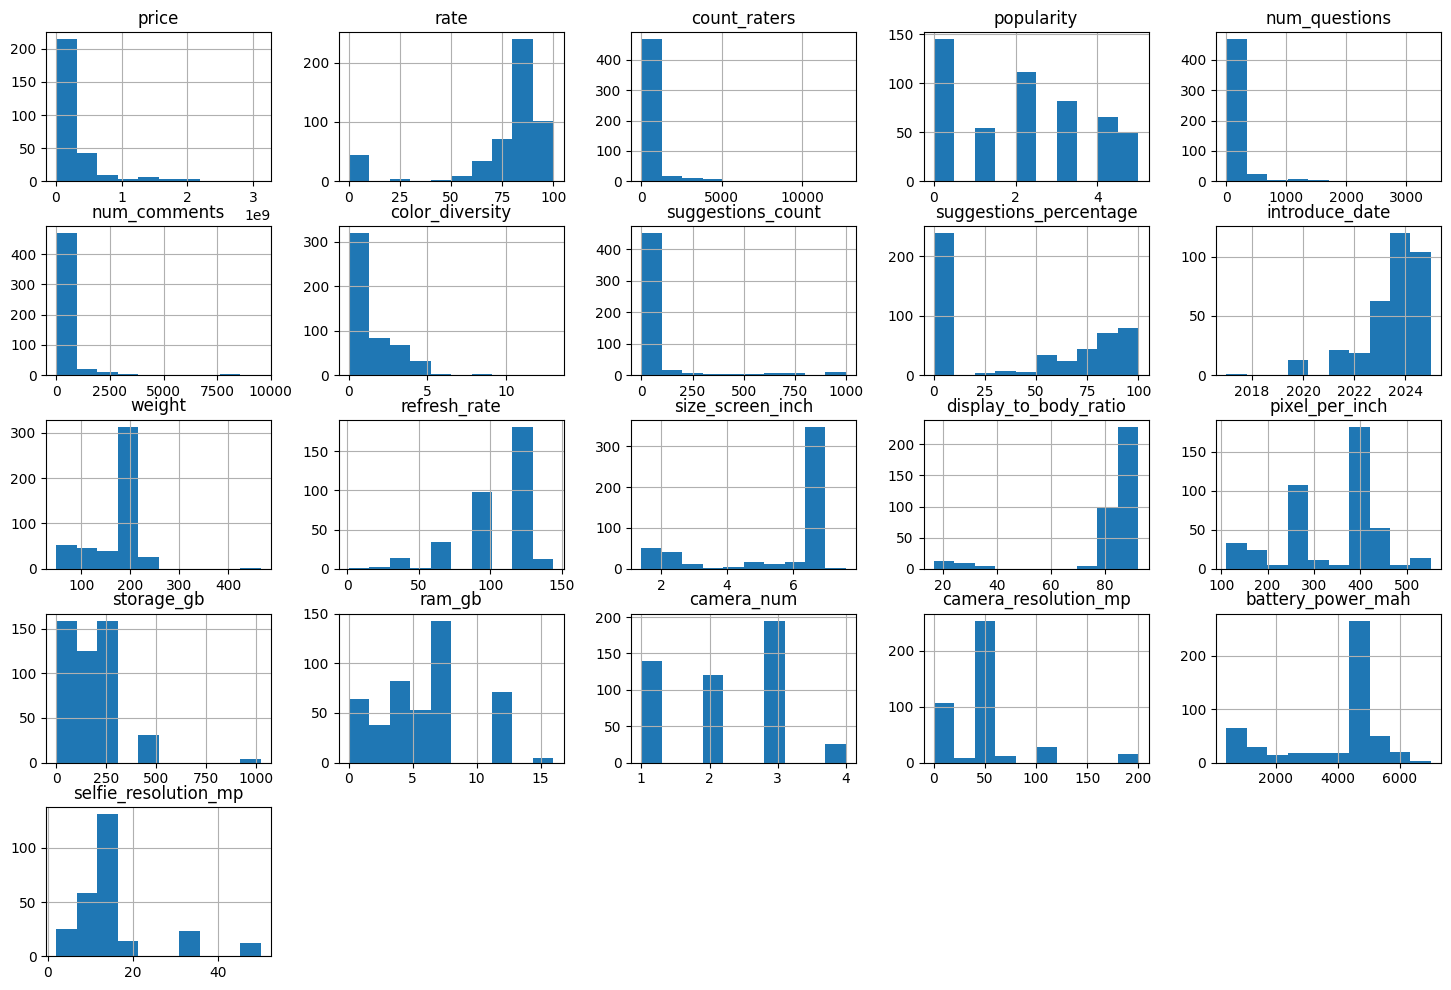

In [8]:
df.hist(figsize=(18,12));

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   brand                   508 non-null    object 
 1   category                392 non-null    object 
 2   price                   286 non-null    float64
 3   rate                    508 non-null    float64
 4   count_raters            508 non-null    int64  
 5   popularity              508 non-null    int64  
 6   num_questions           508 non-null    int64  
 7   num_comments            508 non-null    int64  
 8   color_diversity         508 non-null    int64  
 9   suggestions_count       508 non-null    float64
 10  suggestions_percentage  508 non-null    float64
 11  os                      394 non-null    object 
 12  introduce_date          341 non-null    float64
 13  size                    482 non-null    object 
 14  weight                  478 non-null    fl

In [31]:
df.describe()

,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,suggestions_percentage,introduce_date,...,refresh_rate,size_screen_inch,display_to_body_ratio,pixel_per_inch,storage_gb,ram_gb,camera_num,camera_resolution_mp,battery_power_mah,selfie_resolution_mp
count,2.860000e+02,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,341.000000,...,343.000000,504.000000,360.000000,438.000000,477.000000,456.000000,481.000000,424.000000,497.000000,263.000000
mean,3.015556e+08,75.426702,385.062992,2.033465,116.027559,280.496063,1.275591,59.899606,41.293307,2023.651026,...,101.513120,5.606508,81.435889,336.429224,168.427055,6.204265,2.222453,48.957028,4033.569416,14.938783
std,4.467720e+08,26.105798,1153.051348,1.673810,299.109407,846.595422,1.525210,187.283739,41.268192,1.379975,...,27.185076,1.849300,16.841778,104.224117,155.166790,3.801737,0.930051,38.823404,1641.802355,10.276116
min,6.990000e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,...,1.000000,1.400000,16.600000,111.000000,0.004000,0.004000,1.000000,0.080000,400.000000,2.000000
25%,8.324000e+07,75.437063,6.000000,0.000000,5.000000,9.000000,0.000000,0.000000,0.000000,2023.000000,...,90.000000,5.000000,84.000000,262.000000,64.000000,4.000000,1.000000,20.750000,3030.000000,8.000000
50%,1.659950e+08,84.569024,34.000000,2.000000,21.000000,36.000000,1.000000,0.000000,46.000000,2024.000000,...,120.000000,6.670000,86.000000,385.000000,128.000000,6.000000,2.000000,50.000000,5000.000000,13.000000
75%,3.191451e+08,89.003705,233.250000,3.000000,92.250000,171.250000,2.000000,10.000000,83.000000,2025.000000,...,120.000000,6.700000,87.600000,396.000000,256.000000,8.000000,3.000000,50.000000,5000.000000,16.000000
max,3.120000e+09,100.000000,12707.000000,5.000000,3408.000000,9542.000000,13.000000,999.000000,100.000000,2025.000000,...,144.000000,7.600000,92.500000,552.000000,1024.000000,16.000000,4.000000,200.000000,7000.000000,50.000000


# Split the Data

### CPU Missing 

In [11]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



# --- 1. Preprocessing and Handling Missing Values ---

# Fill NaN values with a placeholder string and convert to lowercase
df['cpu_model'] = df['cpu_model'].fillna('missing_cpu').str.lower().str.strip()


# --- 2. Text Vectorization (TF-IDF) ---

# Initialize TF-IDF Vectorizer
# token_pattern is set to include non-space characters, which helps capture model numbers
vectorizer = TfidfVectorizer(stop_words=None, token_pattern=r'\b\w+\b')

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(df['cpu_model'])


# --- 3. Dimensionality Reduction (PCA) ---

# We use PCA to reduce the large number of features (tokens) to a smaller number
# This makes clustering faster and often more stable.
pca = PCA(n_components=50, random_state=42) # Choosing 50 components as a reasonable number
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())


# --- 4. Clustering (K-Means) ---

# Determine the number of clusters (K).
# Based on the data, we expect around 5-7 brands (MediaTek, Qualcomm, Exynos, Apple, Unisoc, Other, Missing)
K = 6
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")

# Fit K-Means to the data
df['cpu_cluster'] = kmeans.fit_predict(tfidf_reduced)


# --- 5. Inspecting the Clusters ---

print("\n--- Top 20 Unique Models and Their Assigned Cluster ---")
print(df[['cpu_model', 'cpu_cluster']].head(20).sort_values(by='cpu_cluster'))

print("\n--- Summary of Clusters (Representative Values) ---")
for i in range(K):
    # Get all models belonging to the current cluster
    cluster_models = df[df['cpu_cluster'] == i]['cpu_model'].unique()
    
    # Print the size of the cluster and the top few models
    print(f"\nCluster {i} (Size: {len(df[df['cpu_cluster'] == i])}):")
    # Show the most frequent words in this cluster to understand what it represents
    words = ' '.join(cluster_models).split()
    word_counts = pd.Series(words).value_counts().head(5)
    
    print(f"  Representative Words: {list(word_counts.index)}")
    print(f"  Sample Models: {cluster_models[:3].tolist()}...")


--- Top 20 Unique Models and Their Assigned Cluster ---
                          cpu_model  cpu_cluster
5                           sc9863a            2
0                       missing_cpu            3
2                       missing_cpu            3
1                       missing_cpu            3
3                       missing_cpu            3
4                       missing_cpu            3
6                  apple a18 (3 nm)            4
7   apple a15 bionic (5 nm) chipset            4
8          apple a15 bionic chipset            4
9              apple a19 pro (3 nm)            4
10                 apple a18 (3 nm)            4
11  apple a15 bionic (5 nm) chipset            4
12         apple a15 bionic chipset            4
13  apple a17 bionic (3 nm) chipset            4
14  apple a15 bionic (5 nm) chipset            4
15  apple a15 bionic (5 nm) chipset            4
16             apple a18 pro (3 nm)            4
17                 apple a18 (3 nm)            4
18          

In [12]:
df["brand"].value_counts()

brand
samsung            120
xiaomi              60
hanofer-mo          26
apple               20
tcl                 20
miscellaneous       20
blackberry          20
honor               20
realme              20
alcatel             19
oneplus             19
glx                 19
nothing             17
nokia               16
blackview           15
motorola            14
vocal               10
daria                9
dox                  9
tecno-ma             7
general-luxe-it      6
hmd-mobile           5
tch                  5
ruggear              4
redtone              3
otel                 2
zhivaco              2
gionee               1
Name: count, dtype: int64

In [13]:
brand_counts = df['brand'].value_counts()

# 2. Identify the brands where the count is strictly less than 2
rare_brands = brand_counts[brand_counts < 3].index.tolist()

# 3. Define the replacement name
replacement_name = 'other'

# 4. Replace the rare brand names
df["brand"] = df['brand'].replace(rare_brands, replacement_name)

In [14]:
df["brand"].value_counts()

brand
samsung            120
xiaomi              60
hanofer-mo          26
miscellaneous       20
blackberry          20
honor               20
apple               20
tcl                 20
realme              20
glx                 19
alcatel             19
oneplus             19
nothing             17
nokia               16
blackview           15
motorola            14
vocal               10
daria                9
dox                  9
tecno-ma             7
general-luxe-it      6
other                5
tch                  5
hmd-mobile           5
ruggear              4
redtone              3
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

mobile, mobile_test = train_test_split(df,stratify=df["brand"] ,test_size=0.3, random_state=42)

In [16]:
len(mobile) , len(mobile_test)

(355, 153)

In [38]:
mobile.head()

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,cpu_model,storage_gb,ram_gb,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster
118,hanofer-mo,low,14450000.0,75.454545,22,3,18,14,1,0.0,...,mediatek 2502,0.031,0.031,2G,1.0,0.3,NaN,1800.0,NaN,1
181,xiaomi,mid,815700000.0,84.545455,44,2,55,39,1,0.0,...,mediatek dimensity 9300+ (4 nm),1024.000,12.000,5G,3.0,50.0,8K@24FPS,5000.0,NaN,1
502,vocal,low,NaN,86.064982,277,4,246,232,0,0.0,...,helio g99,128.000,6.000,4G,2.0,50.0,NaN,5000.0,8.0,1
309,honor,mid,223887000.0,89.389671,213,3,158,168,3,0.0,...,mediatek dimensity 6080,256.000,8.000,5G,3.0,108.0,NaN,4500.0,NaN,1
499,vocal,low,NaN,86.703297,182,4,195,140,0,0.0,...,helio g99,128.000,4.000,4G,2.0,50.0,NaN,5000.0,8.0,1


# Feature Engineering

## Handling Missing values

#### Category 

In [39]:
num_nan_os = mobile["category"].isna().sum()
print(num_nan_os)

81


* if phone dosnt have cpu and os and (ram or storage) or internet

In [40]:
mobile[mobile["category"] == "low"]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,cpu_model,storage_gb,ram_gb,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster
118,hanofer-mo,low,14450000.0,75.454545,22,3,18,14,1,0.0,...,mediatek 2502,0.031,0.031,2G,1.0,0.3,NaN,1800.0,NaN,1
502,vocal,low,NaN,86.064982,277,4,246,232,0,0.0,...,helio g99,128.000,6.000,4G,2.0,50.0,NaN,5000.0,8.0,1
499,vocal,low,NaN,86.703297,182,4,195,140,0,0.0,...,helio g99,128.000,4.000,4G,2.0,50.0,NaN,5000.0,8.0,1
463,samsung,low,188400000.0,0.000000,0,1,0,0,3,0.0,...,exynos 1330 (5 nm),128.000,4.000,4G,3.0,50.0,1080p@30FPS,5000.0,13.0,4
420,samsung,low,108300000.0,85.853659,205,5,33,129,3,0.0,...,mediatek helio g85 (12 nm),128.000,4.000,4G,2.0,50.0,1080p@30FPS,5000.0,8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,other,low,8490000.0,76.311688,385,5,113,278,1,0.0,...,missing_cpu,NaN,NaN,2G,1.0,NaN,NaN,1000.0,NaN,3
180,xiaomi,low,NaN,86.776860,121,4,31,88,0,0.0,...,helio g81 ultra (12 nm),128.000,6.000,4G,1.0,50.0,NaN,5160.0,13.0,1
403,samsung,low,136250000.0,88.888889,9,1,5,6,2,0.0,...,mediatek helio g99 (6 nm),128.000,6.000,4G,2.0,50.0,1080p@30FPS,5000.0,8.0,1
241,tcl,low,NaN,82.535211,71,0,53,67,0,10.0,...,mediatek helio g36 (12 nm),64.000,4.000,4G,2.0,50.0,1080p@30FPS,5010.0,5.0,1


In [41]:
# Ensure the columns exist; then assign 'low' to category when any condition is met
mask = (
    mobile["cpu_model"].isna() |
    (mobile["ram_gb"] < 2.)|
    (mobile["storage_gb"] < 64.) |
    ((mobile["internet"] == "2G") | (mobile["internet"] == "3G") )|
    (mobile["price"] < 150_000_000))

mobile.loc[mask, "category"] = "low"

In [42]:
num_nan_os = mobile["category"].isna().sum()
print(num_nan_os)

22


In [43]:
mobile['category'] = mobile['category'].fillna('unknown')

In [44]:
mobile["category"].unique()

array(['low', 'mid', 'high', 'unknown'], dtype=object)

In [45]:
mobile[mobile["category"] == "unknown"]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,cpu_model,storage_gb,ram_gb,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster
108,glx,unknown,NaN,60.000000,3,0,0,2,0,0.0,...,missing_cpu,NaN,NaN,no,1.0,NaN,NaN,NaN,NaN,3
64,nothing,unknown,NaN,0.000000,0,1,1,1,0,0.0,...,qualcomm sm7635 snapdragon 7s gen 3 (4 nm),128.0,8.0,5G,3.0,50.0,4K@30FPS,5000.0,50.0,2
252,motorola,unknown,NaN,88.333333,24,1,39,18,0,0.0,...,qualcomm sm7435-ab snapdragon 7s gen 2 (4 nm),256.0,12.0,5G,2.0,50.0,4K@30FPS,5000.0,32.0,2
264,miscellaneous,unknown,NaN,66.666667,3,2,6,3,0,0.0,...,unisoc sc9863a,128.0,4.0,4G,2.0,13.0,NaN,4500.0,5.0,5
31,realme,unknown,NaN,87.419355,62,0,69,117,0,30.0,...,qualcomm sm7125 snapdragon 720g (8 nm) chipset,128.0,8.0,4G,4.0,64.0,4K@30FPS,4500.0,NaN,2
70,nothing,unknown,NaN,0.000000,0,2,2,1,0,0.0,...,qualcomm sm7635 snapdragon 7s gen 3 (4 nm),256.0,8.0,5G,3.0,50.0,4K@30FPS,5000.0,50.0,2
103,glx,unknown,NaN,53.333333,3,0,1,4,0,0.0,...,missing_cpu,NaN,NaN,no,1.0,NaN,NaN,NaN,NaN,3
159,xiaomi,unknown,2.590510e+08,87.608696,92,5,100,84,2,0.0,...,mediatek helio g99 ultra,512.0,12.0,4G,3.0,200.0,1080p@30FPS,5000.0,16.0,1
147,daria,unknown,2.678100e+08,100.000000,1,2,6,3,2,0.0,...,mediatek d8350,512.0,12.0,5G,3.0,50.0,4K@60FPS,5000.0,50.0,1
278,oneplus,unknown,NaN,0.000000,0,0,5,3,0,0.0,...,qualcomm sm8250-ac snapdragon 870 5g chipset,256.0,8.0,5G,4.0,NaN,4K@60FPS,4500.0,NaN,2


#### del color 

In [46]:
mobile["color_diversity"].unique()

array([ 1,  0,  3,  2,  4, 13,  6,  7,  8])

In [47]:
# Ensure the columns exist; then assign 'low' to category when any condition is met
mask = (
    (mobile["color_diversity"] == 0)
)

mobile.loc[mask, "color_diversity"] = 1

In [48]:
mobile["color_diversity"].unique()

array([ 1,  3,  2,  4, 13,  6,  7,  8])

#### os

In [49]:
mobile[mobile["os"].isna()]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,cpu_model,storage_gb,ram_gb,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster
118,hanofer-mo,low,14450000.0,75.454545,22,3,18,14,1,0.0,...,mediatek 2502,0.031,0.031,2G,1.0,0.3,NaN,1800.0,NaN,1
108,glx,unknown,NaN,60.000000,3,0,0,2,1,0.0,...,missing_cpu,NaN,NaN,no,1.0,NaN,NaN,NaN,NaN,3
2,general-luxe-it,low,13950000.0,80.273973,146,3,23,92,1,50.0,...,missing_cpu,0.004,NaN,2G,1.0,NaN,NaN,800.0,NaN,3
4,general-luxe-it,low,19750000.0,80.754717,53,3,12,32,1,10.0,...,missing_cpu,0.004,0.016,2G,1.0,NaN,NaN,1020.0,NaN,3
260,miscellaneous,low,NaN,56.000000,5,0,5,5,1,0.0,...,missing_cpu,0.031,NaN,2G,1.0,NaN,NaN,1200.0,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,other,low,13390000.0,80.000000,1,2,1,0,2,0.0,...,mediatek,NaN,NaN,no,1.0,NaN,NaN,1800.0,NaN,1
190,xiaomi,mid,179990000.0,90.000000,2,1,5,17,3,0.0,...,qualcomm sm6225 snapdragon 685 (6 nm),256.000,8.000,4G,2.0,50.0,1080p@30FPS,7000.0,8.0,0
137,hanofer-mo,low,16400000.0,55.833333,24,3,9,21,1,0.0,...,mediatek mt6260,0.125,0.062,no,1.0,NaN,NaN,1450.0,NaN,1
337,nokia,low,49800000.0,90.616114,211,2,69,89,2,50.0,...,missing_cpu,NaN,NaN,2G,1.0,NaN,NaN,1450.0,NaN,3


In [50]:
mobile["os"] = mobile["os"].fillna("non")

In [51]:
mobile["os"].unique()

array(['non', 'Android', 'iOS', 'BlackBerry OS'], dtype=object)

#### introduce_date

In [52]:
mobile["introduce_date"].unique()

array([  nan, 2024., 2023., 2021., 2025., 2022., 2020., 2017.])

In [53]:
mobile["introduce_date"] = mobile["introduce_date"].fillna("unknown")

In [54]:
mobile["introduce_date"].unique()

array(['unknown', 2024.0, 2023.0, 2021.0, 2025.0, 2022.0, 2020.0, 2017.0],
      dtype=object)

#### size

In [55]:
mobile["size"]

118          13.5x56x141
181       160.4x75.1x8.4
502     163.69x75.69x8.5
309       161.1x74.6x6.8
499     163.69x75.69x8.5
             ...        
432         164x77.5x7.7
241       168.3x76.7x8.3
299    163.19x75.02x8.45
488       8.1x75.5x155.8
154       171.9x77.8x8.2
Name: size, Length: 355, dtype: object

In [56]:
import numpy as np

def extract_size_features(size_str):
    """
    Parse the 'size' string (e.g. '160x75x8.5') and return (thickness, volume).
    Returns (np.nan, np.nan) if parsing fails.
    """
    try:
        # Ensure string and remove spaces
        parts = str(size_str).replace(" ", "").split("x")
        if len(parts) != 3:
            return np.nan, np.nan
        nums = [float(p) for p in parts]
        thickness = min(nums)
        volume = nums[0] * nums[1] * nums[2]
        volume_cm3 = volume / 1000
        return thickness, volume_cm3
    except Exception:
        return np.nan, np.nan

# Apply to DataFrame
mobile[["thickness", "volume"]] = mobile["size"].apply(lambda x: pd.Series(extract_size_features(x)))

<Axes: >

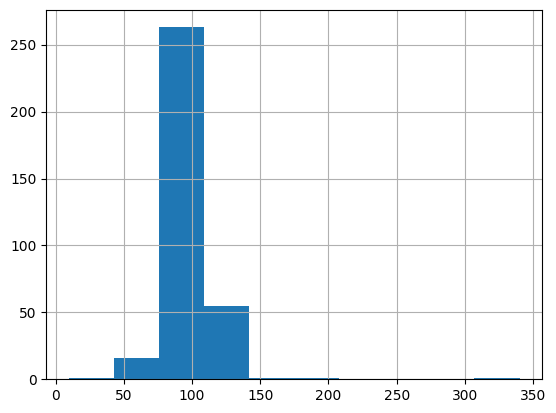

In [57]:
mobile["volume"].hist()

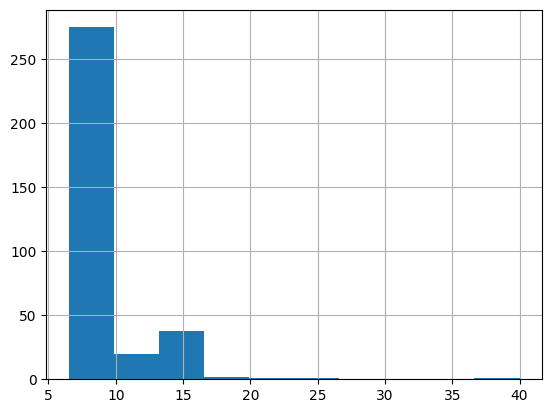

In [58]:
mobile["thickness"].hist();

In [36]:
mobile["size"].dtype

dtype('O')

In [37]:
mobile["size"].isna().sum()

np.int64(17)

In [38]:
mobile["size"] = mobile["size"].fillna("unknown")

#### Weight

In [39]:
mobile["weight"]

118     98.0
181    209.0
502      NaN
309    166.0
499      NaN
       ...  
432    200.0
241    190.0
299    187.0
488    167.0
154    204.0
Name: weight, Length: 355, dtype: float64

In [40]:
mobile["weight"].isna().sum()

np.int64(23)

In [41]:
weight_average = (mobile["weight"].sum() / len(mobile)).round(1)
weight_average

np.float64(162.7)

In [42]:
mobile["weight"] = mobile["weight"].fillna(weight_average)

#### *Density

In [59]:
mobile["density"] = mobile["weight"] / mobile["volume"]

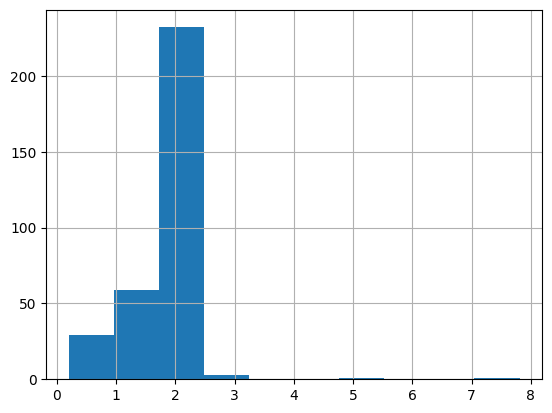

In [60]:
mobile["density"].hist();

#### Display tech

In [45]:
mobile["display_technology"].unique()

array([nan, 'AMOLED', 'LED', 'LCD', 'Super AMOLED', 'IPS', 'IPS LCD',
       'Super Retina XDR OLED', 'TFT', 'PLS', 'P-OLED',
       'Dynamic AMOLED 2X', 'LTPO3 Fluid AMOLED',
       'LTPO Super Retina XDR OLED', 'Super AMOLED Plus', 'Fluid AMOLED',
       'PLS TFT', 'LTPO AMOLED', 'Foldable OLED', 'TN', 'OLED',
       'LTPO2 Fluid AMOLED', 'LTPS', 'Dynamic LTPO AMOLED 2X',
       'LTPO OLED'], dtype=object)

In [46]:
mobile["display_technology"].isna().sum()

np.int64(21)

In [47]:
mobile["display_technology"] = mobile["display_technology"].fillna("unknown")

#### Display to body ratio

In [67]:
mobile["display_to_body_ratio"].unique()

array([26.8 , 89.1 ,   nan, 89.9 , 86.  , 82.1 , 85.8 , 87.4 , 86.7 ,
       86.5 , 83.8 , 88.4 , 91.4 , 72.1 , 91.6 , 87.7 , 84.  , 90.7 ,
       92.2 , 85.1 , 85.6 , 84.3 , 90.1 , 84.2 , 83.9 , 88.  , 18.2 ,
       84.9 , 85.7 , 16.6 , 82.7 , 85.5 , 84.6 , 89.7 , 76.6 , 87.5 ,
       88.8 , 87.3 , 84.7 , 83.2 , 86.8 , 88.9 , 82.9 , 32.  , 89.  ,
       86.4 , 86.3 , 85.4 , 87.1 , 83.7 , 19.5 , 84.1 , 86.2 , 88.5 ,
       85.9 , 90.  , 89.2 , 74.6 , 79.8 , 87.9 , 83.5 , 90.8 , 81.7 ,
       85.2 , 86.1 , 90.3 , 82.6 , 27.5 , 17.6 , 89.8 , 26.9 , 82.  ,
       28.1 , 83.4 , 88.3 , 77.5 , 87.6 , 75.1 , 87.2 , 89.12])

In [49]:
mobile["display_to_body_ratio"].isna().sum()

np.int64(102)

In [50]:


# 1. Define the Bin Boundaries (BINS) and Labels
bins = [0, 50, 87, 100]
labels = ['low', 'mid', 'high']

# 2. Apply the cut function
mobile["display_to_body_ratio"] = pd.cut(
    mobile["display_to_body_ratio"],
    bins=bins,
    labels=labels,
    right=False ,
    ordered=False
)



In [51]:
new_value = 'unknown'
# --- FIX ---

# 2. Add the new value to the list of allowed categories
current_categories = mobile["display_to_body_ratio"].cat.categories.tolist()
if new_value not in current_categories:
    new_categories = current_categories + [new_value]
    mobile["display_to_body_ratio"]  =  mobile["display_to_body_ratio"].cat.set_categories(new_categories)

mobile["display_to_body_ratio"] = mobile["display_to_body_ratio"].fillna("unknown")

In [52]:
mobile["display_to_body_ratio"].unique()

['low', 'high', 'unknown', 'mid']
Categories (4, object): ['low', 'mid', 'high', 'unknown']

##### Noise

invalid_mask = df['display_to_body_ratio'] > 100


df.loc[invalid_mask, 'display_to_body_ratio'] = np.nan


mean_ratio = df['display_to_body_ratio'].mean()

print(f"Calculated Mean Ratio (excluding NaNs): {mean_ratio:.2f}")

df.loc[invalid_mask, 'display_to_body_ratio'] = mean_ratio



#### Refresh Rate

In [62]:
mobile["refresh_rate"].unique()

array([ 30., 144., 120.,  90.,  60.,  nan,  20.,  50.])

In [65]:
bins_display_refresh_rate = [0, 50, 90, 180]
labels = ['low', 'mid', 'high']

mobile["refresh_rate"] = pd.cut(
    mobile["refresh_rate"],
    bins=bins_display_refresh_rate,
    labels=labels,
    ordered=False
)

In [54]:
mobile["refresh_rate"] = mobile["refresh_rate"].fillna("unknown")

In [66]:
mobile["refresh_rate"].unique()

['low', 'high', 'mid', NaN]
Categories (3, object): ['low', 'mid', 'high']

#### Size Screen

In [56]:
mobile["size_screen_inch"].unique()

array([2.4 , 6.67, 6.6 , 6.7 , 6.1 , 6.77, 6.88, 1.77, 5.45, 6.78, 4.5 ,
       4.2 , 6.79, 6.75, 6.9 , 6.5 , 6.55, 6.74, 6.56, 5.  , 6.61, 6.58,
       6.4 ,  nan, 5.99, 6.8 , 2.8 , 6.72, 2.  , 3.5 , 6.53, 6.82, 6.73,
       4.3 , 3.1 , 6.52, 5.5 , 1.4 , 1.8 , 6.43, 6.  , 1.7 , 6.62, 4.7 ,
       5.2 , 6.71, 4.6 , 6.2 , 2.5 , 5.7 ])

In [57]:
mobile["size_screen_inch"] = mobile["size_screen_inch"].fillna(mobile["size_screen_inch"].median())

#### PPI

In [58]:
mobile["pixel_per_inch"].unique()

array([ nan, 446., 394., 385., 262., 390., 264., 460., 395., 387., 260.,
       295., 393., 437., 453., 444., 355., 396., 254., 320., 402., 269.,
       167., 294., 111., 266., 143., 113., 411., 267., 263., 525., 403.,
       389., 442., 268., 526., 392., 165., 261., 552., 217., 328., 433.,
       540., 129., 265., 114., 410., 457., 179., 397., 409., 312., 278.,
       270., 424., 510., 245., 236., 271., 498., 405., 282., 160., 291.,
       534., 399., 436., 286., 441., 388., 458., 316., 374., 116., 228.,
       505.])

In [59]:
mobile["pixel_per_inch"] = mobile["pixel_per_inch"].fillna(mobile["pixel_per_inch"].median())

#### Storage

In [60]:
mobile["storage_gb"].unique()

array([3.100e-02, 1.024e+03, 1.280e+02, 2.560e+02,       nan, 6.400e+01,
       4.000e-03, 1.600e+01, 3.200e+01, 5.120e+02, 8.000e-03, 1.250e-01,
       5.000e-01, 4.000e+00, 6.200e-02, 8.000e+00, 1.600e-02, 2.300e-02])

In [61]:
mobile[mobile["storage_gb"].isna()]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster,thickness,volume,density
108,glx,unknown,NaN,60.000000,3,0,0,2,1,0.0,...,no,1.0,NaN,NaN,NaN,NaN,3,14.0,86.814000,0.956067
265,miscellaneous,low,NaN,74.678112,233,0,15,155,1,70.0,...,2G,1.0,NaN,NaN,800.0,NaN,3,13.0,101.556000,0.945291
354,alcatel,low,39290000.0,76.024096,166,3,53,127,2,40.0,...,2G,1.0,1.3,NaN,970.0,NaN,1,16.9,87.731280,1.014461
107,glx,low,30990000.0,82.285714,35,2,38,20,3,0.0,...,no,NaN,NaN,NaN,1650.0,NaN,3,25.0,137.700000,1.053014
103,glx,unknown,NaN,53.333333,3,0,1,4,1,0.0,...,no,1.0,NaN,NaN,NaN,NaN,3,14.0,9.604000,7.809246
100,glx,unknown,NaN,60.000000,1,0,0,1,1,0.0,...,no,1.0,NaN,NaN,NaN,NaN,3,13.2,74.382000,1.384744
216,dox,low,NaN,50.000000,2,0,1,2,1,0.0,...,2G,1.0,NaN,NaN,800.0,NaN,3,12.9,73.288125,1.282609
274,miscellaneous,low,NaN,0.000000,0,0,2,1,1,0.0,...,no,1.0,NaN,NaN,1200.0,NaN,3,NaN,NaN,NaN
258,miscellaneous,low,NaN,56.000000,5,0,3,4,1,0.0,...,2G,3.0,NaN,NaN,1200.0,NaN,3,NaN,NaN,NaN
95,glx,low,12240000.0,81.723731,847,5,180,607,1,10.0,...,no,NaN,NaN,NaN,1650.0,NaN,3,14.0,69.300000,1.399711


In [62]:
mobile["storage_gb"] = mobile["storage_gb"].fillna(0)

#### RAM

In [63]:
mobile["ram_gb"].unique()

array([3.10e-02, 1.20e+01, 6.00e+00, 8.00e+00, 4.00e+00,      nan,
       1.00e+00, 3.00e+00, 2.00e+00, 1.60e-02, 4.00e-03, 8.00e-03,
       2.30e-02, 1.60e+01, 6.20e-02, 1.25e-01, 2.50e-01, 5.00e-01,
       7.50e-01])

In [64]:
mobile[mobile["ram_gb"].isna()]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster,thickness,volume,density
108,glx,unknown,NaN,60.000000,3,0,0,2,1,0.0,...,no,1.0,NaN,NaN,NaN,NaN,3,14.0,86.814000,0.956067
2,general-luxe-it,low,13950000.0,80.273973,146,3,23,92,1,50.0,...,2G,1.0,NaN,NaN,800.0,NaN,3,15.0,87.000000,0.804598
260,miscellaneous,low,NaN,56.000000,5,0,5,5,1,0.0,...,2G,1.0,NaN,NaN,1200.0,NaN,3,NaN,NaN,NaN
266,miscellaneous,low,NaN,85.714286,7,0,3,7,1,0.0,...,2G,1.0,NaN,NaN,800.0,NaN,2,14.8,83.631840,0.848959
354,alcatel,low,39290000.0,76.024096,166,3,53,127,2,40.0,...,2G,1.0,1.3,NaN,970.0,NaN,1,16.9,87.731280,1.014461
1,general-luxe-it,low,12310000.0,77.388535,628,4,59,403,1,200.0,...,2G,NaN,NaN,NaN,800.0,NaN,3,15.0,77.550000,0.902643
111,glx,low,29290000.0,77.935103,339,3,127,221,1,0.0,...,no,1.0,NaN,NaN,1200.0,NaN,3,22.0,122.364000,1.329639
270,miscellaneous,low,NaN,51.428571,7,0,8,5,1,0.0,...,2G,1.0,NaN,NaN,800.0,NaN,2,14.8,83.631840,0.831023
107,glx,low,30990000.0,82.285714,35,2,38,20,3,0.0,...,no,NaN,NaN,NaN,1650.0,NaN,3,25.0,137.700000,1.053014
103,glx,unknown,NaN,53.333333,3,0,1,4,1,0.0,...,no,1.0,NaN,NaN,NaN,NaN,3,14.0,9.604000,7.809246


In [65]:
mobile["ram_gb"] = mobile["ram_gb"].fillna(0)

#### Internet

In [66]:
mobile["internet"].unique()

array(['2G', '5G', '4G', 'no', '3G'], dtype=object)

In [67]:
mobile["internet"].isna().sum()

np.int64(0)

#### Camera Num

In [68]:
mobile["camera_num"].unique()

array([ 1.,  3.,  2.,  4., nan])

In [69]:
mobile["camera_num"].isna().sum()

np.int64(17)

In [70]:
mobile[mobile["camera_num"].isna()]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster,thickness,volume,density
121,hanofer-mo,low,10190000.0,77.575758,33,4,10,24,4,0.0,...,2G,NaN,NaN,NaN,1200.0,NaN,1,12.1,87.725000,0.897122
1,general-luxe-it,low,12310000.0,77.388535,628,4,59,403,1,200.0,...,2G,NaN,NaN,NaN,800.0,NaN,3,15.0,77.550000,0.902643
131,hanofer-mo,low,9850000.0,73.220339,59,4,12,34,6,0.0,...,no,NaN,NaN,NaN,1000.0,NaN,1,12.1,87.725000,0.914221
107,glx,low,30990000.0,82.285714,35,2,38,20,3,0.0,...,no,NaN,NaN,NaN,1650.0,NaN,3,25.0,137.700000,1.053014
142,tch,low,26990000.0,0.000000,0,1,14,3,2,0.0,...,no,NaN,NaN,NaN,2500.0,NaN,5,NaN,NaN,NaN
123,hanofer-mo,low,6990000.0,61.408451,142,4,21,89,7,0.0,...,no,NaN,NaN,NaN,800.0,NaN,3,NaN,NaN,NaN
133,hanofer-mo,low,10100000.0,60.000000,1,2,3,2,8,0.0,...,no,NaN,NaN,NaN,1000.0,NaN,2,14.5,87.725000,0.649758
262,miscellaneous,low,9890000.0,60.952381,21,3,7,14,2,0.0,...,2G,NaN,NaN,NaN,800.0,NaN,2,14.4,79.263360,0.885655
339,alcatel,low,NaN,62.000000,20,0,0,21,1,10.0,...,2G,NaN,NaN,NaN,400.0,NaN,3,13.0,63.388000,0.930776
336,nokia,low,NaN,80.684211,2660,2,211,1709,1,999.0,...,2G,NaN,NaN,NaN,1020.0,NaN,3,15.0,99.990000,0.913091


In [71]:
mobile["camera_num"] = mobile["camera_num"].fillna(0)

#### camera_resolution_mp

In [72]:
mobile["camera_resolution_mp"].isna().sum()

np.int64(57)

In [68]:
mobile["camera_resolution_mp"].unique()

array([  0.3,  50. , 108. ,  12. ,   nan,  13. ,   5. ,   8. ,   1.3,
        64. ,  48. , 200. ,   2. ,  16. ,  32. ,  18. ,  21. ,  20. ])

In [73]:
mobile[mobile["camera_num"] == 0 & mobile["camera_resolution_mp"].isna()]

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster,thickness,volume,density
121,hanofer-mo,low,10190000.0,77.575758,33,4,10,24,4,0.0,...,2G,0.0,NaN,NaN,1200.0,NaN,1,12.1,87.725000,0.897122
1,general-luxe-it,low,12310000.0,77.388535,628,4,59,403,1,200.0,...,2G,0.0,NaN,NaN,800.0,NaN,3,15.0,77.550000,0.902643
131,hanofer-mo,low,9850000.0,73.220339,59,4,12,34,6,0.0,...,no,0.0,NaN,NaN,1000.0,NaN,1,12.1,87.725000,0.914221
107,glx,low,30990000.0,82.285714,35,2,38,20,3,0.0,...,no,0.0,NaN,NaN,1650.0,NaN,3,25.0,137.700000,1.053014
142,tch,low,26990000.0,0.000000,0,1,14,3,2,0.0,...,no,0.0,NaN,NaN,2500.0,NaN,5,NaN,NaN,NaN
123,hanofer-mo,low,6990000.0,61.408451,142,4,21,89,7,0.0,...,no,0.0,NaN,NaN,800.0,NaN,3,NaN,NaN,NaN
133,hanofer-mo,low,10100000.0,60.000000,1,2,3,2,8,0.0,...,no,0.0,NaN,NaN,1000.0,NaN,2,14.5,87.725000,0.649758
262,miscellaneous,low,9890000.0,60.952381,21,3,7,14,2,0.0,...,2G,0.0,NaN,NaN,800.0,NaN,2,14.4,79.263360,0.885655
339,alcatel,low,NaN,62.000000,20,0,0,21,1,10.0,...,2G,0.0,NaN,NaN,400.0,NaN,3,13.0,63.388000,0.930776
336,nokia,low,NaN,80.684211,2660,2,211,1709,1,999.0,...,2G,0.0,NaN,NaN,1020.0,NaN,3,15.0,99.990000,0.913091


In [74]:
mobile["camera_resolution_mp"] = mobile["camera_resolution_mp"].fillna(0)

#### Battery


In [75]:
mobile["battery_power_mah"].unique()

array([1800., 5000., 4500., 3240.,   nan, 5110., 5200.,  800., 2500.,
       5160., 6600., 3450., 6000., 5030., 5010., 1020., 3279., 1200.,
       4700., 2880.,  970., 5300., 3095., 1000., 4000., 2800., 1650.,
       3561., 1500., 5825., 1300., 4685., 5410., 1400., 2100., 3505.,
       3410.,  400., 5150., 5500.,  650., 4900., 4005., 3000., 4470.,
       4400.,  850., 3950., 4800., 1450., 2200., 2610., 1700., 1600.,
       3400., 4020., 5050., 3020., 1150., 4441., 4300., 1230., 5100.,
       3030., 4352., 7000., 4832.])

In [76]:
mobile[mobile["battery_power_mah"] == 0] = mobile["battery_power_mah"].median()

In [77]:
mobile["battery_power_mah"] = mobile["battery_power_mah"].fillna(mobile["battery_power_mah"].median())

#### video 

In [78]:
mobile["video"].unique()

array([nan, '8K@24FPS', '1080p@30FPS', '4K@30FPS', '4K@24FPS',
       '720p@30FPS', '1080p@60FPS', '1440p@30FPS', '1080p@720FPS',
       '4K@60FPS', '480p@15FPS', '4K@120FPS', '8K@30FPS', '720p@480FPS',
       '2160p@30FPS'], dtype=object)

In [79]:
mobile["video"] = mobile["video"].fillna("unknown")

In [80]:
del mobile["selfie_resolution_mp"]

In [81]:
mobile["cpu_cluster"] = mobile["cpu_cluster"].astype("object")

#### Price

In [ ]:
# 1. Define the Bin Boundaries (BINS) and Labels
bins = [0, 50_000_000,100_000_000 ,150_000_000,200_000_000,300_000_000,500_000_000,1000_000_000,1500_000_000,2000_000_000,5000_000_000]
labels = ['0', '1', '2','3','4','5','6','7','8','9']

# 2. Apply the cut function
mobile["price"] = pd.cut(
    mobile["price"],
    bins=bins,
    labels=labels,
    ordered=True
)


In [83]:
new_value = 'unknown'
# --- FIX ---

# 2. Add the new value to the list of allowed categories
current_categories = mobile["price"].cat.categories.tolist()
if new_value not in current_categories:
    new_categories = current_categories + [new_value]
    mobile["price"]  =  mobile["price"].cat.set_categories(new_categories)

mobile["price"] = mobile["price"].fillna("unknown")

In [ ]:
mobile[mobile["price"]=="unknown"] 

,brand,category,price,rate,count_raters,popularity,num_questions,num_comments,color_diversity,suggestions_count,...,cpu_model,storage_gb,ram_gb,internet,camera_num,camera_resolution_mp,video,battery_power_mah,selfie_resolution_mp,cpu_cluster


In [ ]:
del mobile["cpu_model"]
del mobile["size"]

In [89]:
mobile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 118 to 154
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   brand                   355 non-null    object  
 1   category                355 non-null    object  
 2   price                   355 non-null    category
 3   rate                    355 non-null    float64 
 4   count_raters            355 non-null    int64   
 5   popularity              355 non-null    int64   
 6   num_questions           355 non-null    int64   
 7   num_comments            355 non-null    int64   
 8   color_diversity         355 non-null    int64   
 9   suggestions_count       355 non-null    float64 
 10  suggestions_percentage  355 non-null    float64 
 11  os                      355 non-null    object  
 12  introduce_date          355 non-null    object  
 13  weight                  355 non-null    float64 
 14  display_technology      355 n

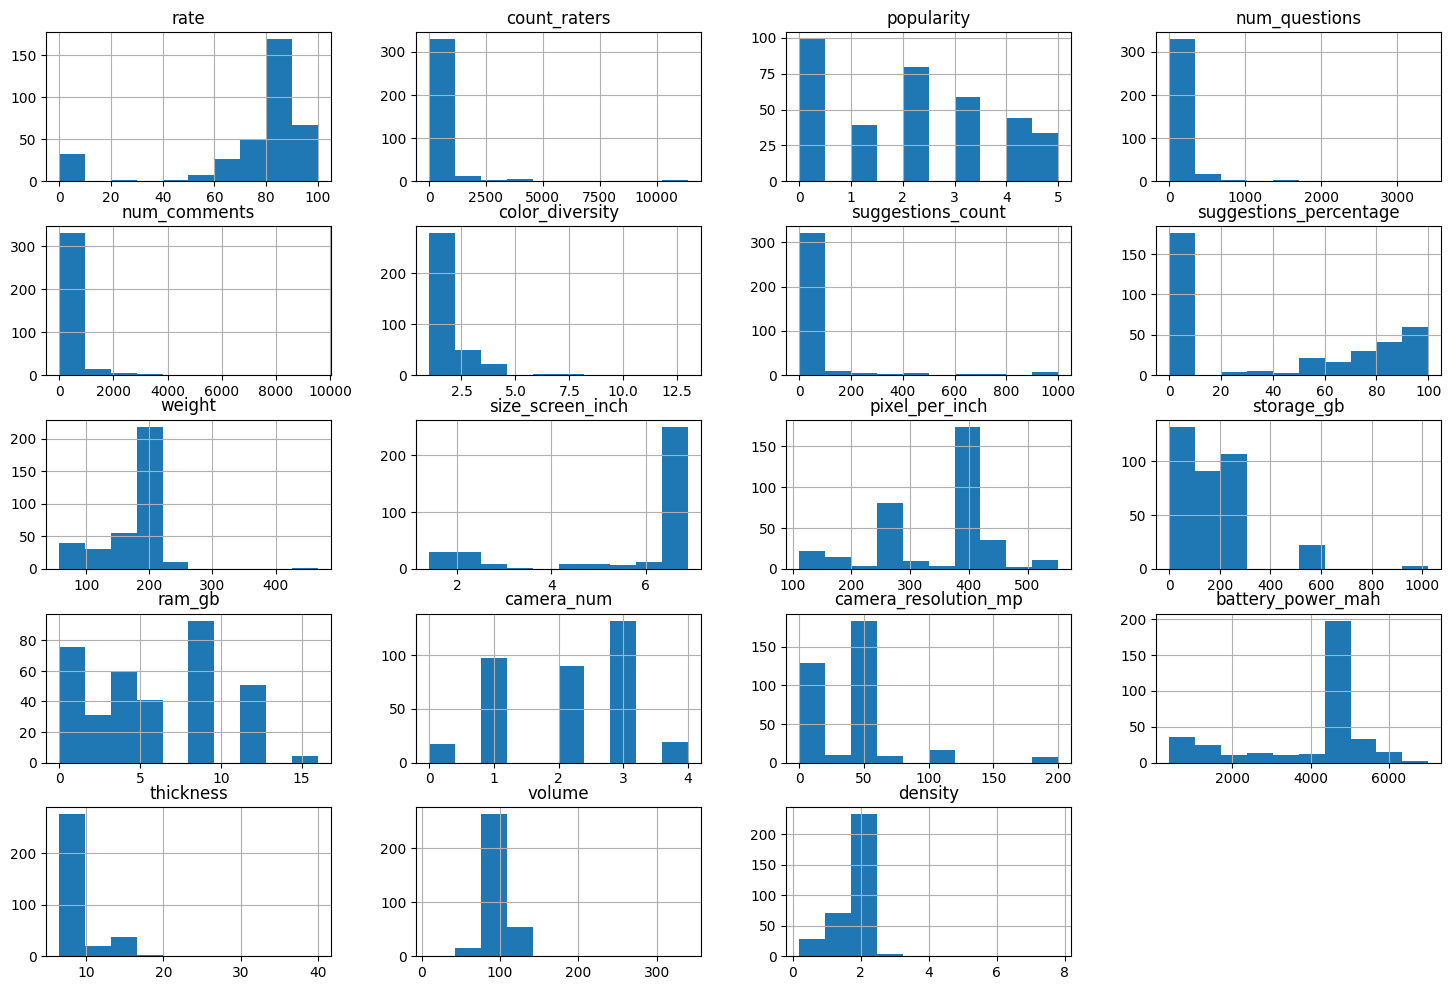

In [91]:
mobile.hist(figsize=(18,12));